In [ ]:
# cm1 with just cosine similarity

Generating CM1 comparisons with tuned parameters...

Found 28 compounds
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 2
Processing same-compound comparisons for compound 3
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 5
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 7
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 9
Processing same-compound comparisons for compound 10
Processing same-compound comparisons for compound 11
Processing same-compound comparisons for compound 12
Processing same-compound comparisons for compound 13
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 15
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 17
Processing same-compound comparisons

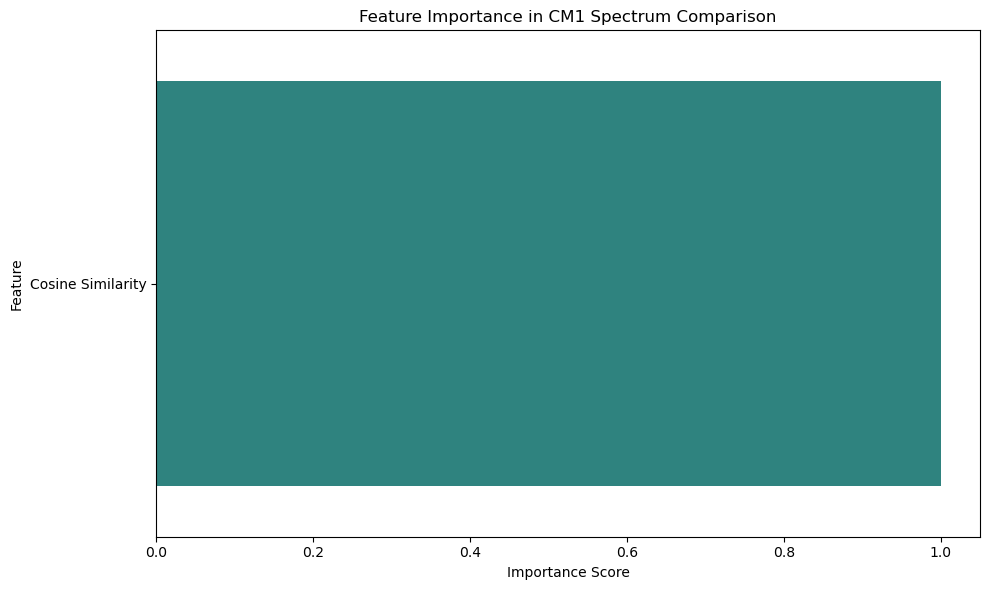


Feature Importance Rankings:
Cosine Similarity    1.0000

Confusion Matrix:


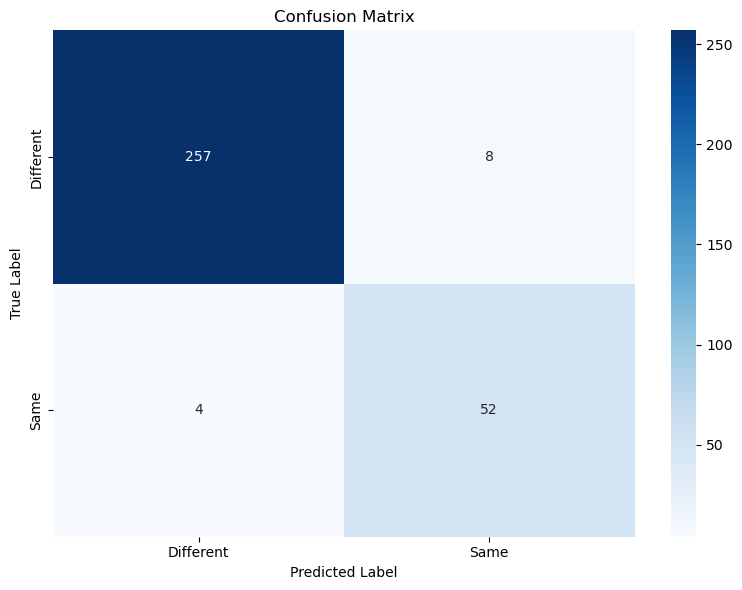


Tuned model and scaler saved!


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Function to read mass spectra data from CSV
def load_spectrum(filepath):
    """Reads CSV file containing mass spectrum data
    Returns: m/z values and intensity values"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)  # Skip header row
        mz = spectrum['X(Thompsons)'].values         # Mass/charge values
        intensities = spectrum['Y(Counts)'].values    # Intensity values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

# Function to preprocess and align two spectra
def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Aligns two spectra for comparison by:
    1. Creating common m/z axis
    2. Interpolating intensities
    3. Normalizing intensities to [0,1] range"""
    try:
        # Find overlapping m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create uniform m/z axis with 1000 points
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Interpolate intensities to match common m/z axis
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities to [0,1] range
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

# Function to calculate cosine similarity only
def calculate_similarity_features(mz, int1, int2):
    """Calculates cosine similarity between spectra vectors"""
    try:
        # Calculate cosine similarity (angle between vectors)
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Check for invalid values
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

# Function to check if compound files exist
def check_compound_existence(base_path, compound_num):
    """Checks if at least one spectrum file exists for a compound"""
    for i in range(1, 11):
        if os.path.exists(f"{base_path}/{compound_num:02d}-{i:02d}.csv"):
            return True
    return False

# Main function to generate comparison dataset
def generate_balanced_comparisons(base_path, debug=False):
    """Creates balanced dataset of spectrum comparisons:
    - Positive class (y=1): Same compound comparisons
    - Negative class (y=0): Different compound comparisons"""
    X = []  # Features
    y = []  # Labels
    comparisons = []  # File pairs
    same_count = 0    # Count of same-compound pairs
    diff_count = 0    # Count of different-compound pairs
    
    # Find all existing compounds
    existing_compounds = []
    for compound_i in range(1, 29):  # CM1 has 28 compounds
        if check_compound_existence(base_path, compound_i):
            existing_compounds.append(compound_i)
    
    if debug:
        print(f"\nFound {len(existing_compounds)} compounds")
        
    # Generate same-compound comparisons
    for compound_i in existing_compounds:
        if debug:
            print(f"Processing same-compound comparisons for compound {compound_i}")
            
        # Compare first 5 spectra of each compound
        for i in range(1, 5):
            for j in range(i + 1, 6):
                file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                file2 = f"{base_path}/{compound_i:02d}-{j:02d}.csv"
                
                if not os.path.exists(file1) or not os.path.exists(file2):
                    continue
                    
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((file1, file2))
                    same_count += 1
    
    # Generate different-compound comparisons
    for idx, compound_i in enumerate(existing_compounds[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound_i}")
            
        # Compare with next 2 compounds for balance
        for compound_j in existing_compounds[idx+1:min(idx+3, len(existing_compounds))]:
            for i in range(1, 6):
                for j in range(1, 6):
                    file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                    file2 = f"{base_path}/{compound_j:02d}-{j:02d}.csv"
                    
                    if not os.path.exists(file1) or not os.path.exists(file2):
                        continue
                    
                    features = calculate_similarity_features(
                        *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                    )
                    
                    if features is not None:
                        X.append(list(features.values()))
                        y.append(0)  # Different compounds
                        comparisons.append((file1, file2))
                        diff_count += 1
    
    # Print dataset statistics
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

# Function to visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """Creates and plots confusion matrix for model evaluation"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Different', 'Same'],
                yticklabels=['Different', 'Same'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    return cm

# Main execution function
def main():
    # Set data path
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1'
    
    # Generate dataset
    print("Generating CM1 comparisons with tuned parameters...")
    X, y, comparisons = generate_balanced_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split data into train/test sets and scale features
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create XGBoost model with optimized parameters
        model = xgb.XGBClassifier(
            # Tree parameters
            max_depth=4,
            min_child_weight=2,
            gamma=0.1,
            
            # Sampling parameters
            subsample=0.9,
            colsample_bytree=0.9,
            
            # Learning parameters
            learning_rate=0.005,
            n_estimators=300,
            
            # Class weight for imbalance
            scale_pos_weight=4,
            
            # Regularization
            reg_lambda=0.8,
            reg_alpha=0.1,
            
            # Other settings
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False
        )
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate model performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Analyze feature importance
        feature_names = ['Cosine Similarity']  # Changed to single feature
        importance = model.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in CM1 Spectrum Comparison')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Print feature rankings
        print("\nFeature Importance Rankings:")
        for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
            print(f"{name:20} {imp:.4f}")
        
        # Show confusion matrix
        print("\nConfusion Matrix:")
        cm = plot_confusion_matrix(y_test, y_pred)
        
        # Save model and scaler
        try:
            model.save_model('cm1_comparison_model_tuned.json')
            joblib.dump(scaler, 'cm1_scaler_tuned.joblib')
            print("\nTuned model and scaler saved!")
        except Exception as e:
            print(f"Error saving model: {str(e)}")

# Execute main function if script is run directly
if __name__ == "__main__":
    main()

In [ ]:
#cm2 with only cosine similarity

Generating CM2 comparisons using cosine similarity only...

Found 580 spectra files
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 43
Processing same-compound comparisons for compound 18
Processing same-compound comparisons for compound 30
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 53
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 20
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 51
Processing same-compound comparisons for compound 22
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 41
Processing same-compound comparisons for compound 32
Processing same-compound comparisons for compound 37
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 54
Processing same-com

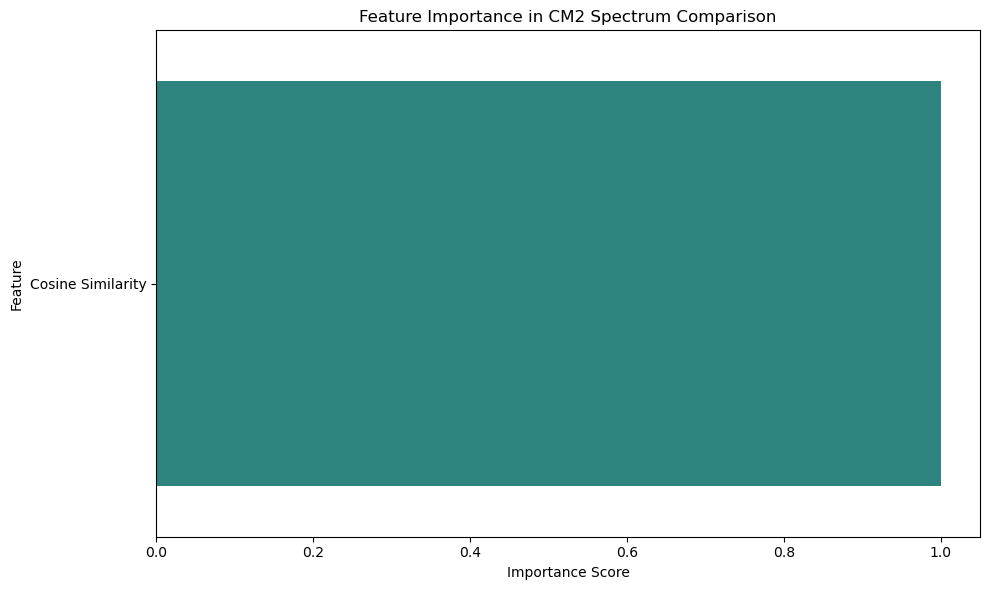


Feature Importance Rankings:
Cosine Similarity    1.0000


In [5]:
#CM2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate cosine similarity between aligned spectra"""
    try:
        # Only calculate cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def generate_comparisons(base_path, debug=False):
    """Generate comparison dataset for CM2"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    # Find all spectra files
    spectra_files = []
    for file in os.listdir(base_path):
        if file.endswith('.csv'):
            spectra_files.append(file)
    
    if debug:
        print(f"\nFound {len(spectra_files)} spectra files")
    
    # Group files by compound
    compounds = {}
    for file in spectra_files:
        compound_num = int(file.split('-')[0])
        if compound_num not in compounds:
            compounds[compound_num] = []
        compounds[compound_num].append(file)
    
    # Generate same-compound comparisons
    for compound in compounds:
        files = compounds[compound]
        if debug:
            print(f"Processing same-compound comparisons for compound {compound}")
            
        for i, file1 in enumerate(files[:-1]):
            for file2 in files[i+1:]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((path1, path2))
                    same_count += 1
    
    # Generate different-compound comparisons
    compounds_list = list(compounds.keys())
    for i, compound1 in enumerate(compounds_list[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound1}")
            
        # Compare with next compound for balance
        compound2 = compounds_list[i+1]
        for file1 in compounds[compound1]:
            for file2 in compounds[compound2]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((path1, path2))
                    diff_count += 1
    
    # Print dataset statistics
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

def main():
    # Set path for CM2
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2'
    
    # Generate comparisons
    print("Generating CM2 comparisons using cosine similarity only...")
    X, y, comparisons = generate_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Create model with same anti-overfitting measures
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        print("\nPerforming cross-validation...")
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance analysis
        feature_names = ['Cosine Similarity']  # Modified for single feature
        importance = model.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in CM2 Spectrum Comparison')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Print feature importance rankings
        print("\nFeature Importance Rankings:")
        for idx, row in importance_df.iloc[::-1].iterrows():
            print(f"{row['Feature']:20} {row['Importance']:.4f}")
        
if __name__ == "__main__":
    main()

In [ ]:
#cm3 with only cosine similarity

Generating CM3 comparisons (using only Cosine Similarity)...

Found 49 compounds
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 43
Processing same-compound comparisons for compound 18
Processing same-compound comparisons for compound 30
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 20
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 22
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 41
Processing same-compound comparisons for compound 32
Processing same-compound comparisons for compound 37
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 29
Processing same-compound comparisons for compound 25
Processing same-compound comparisons for compound 13
Processing same-compou

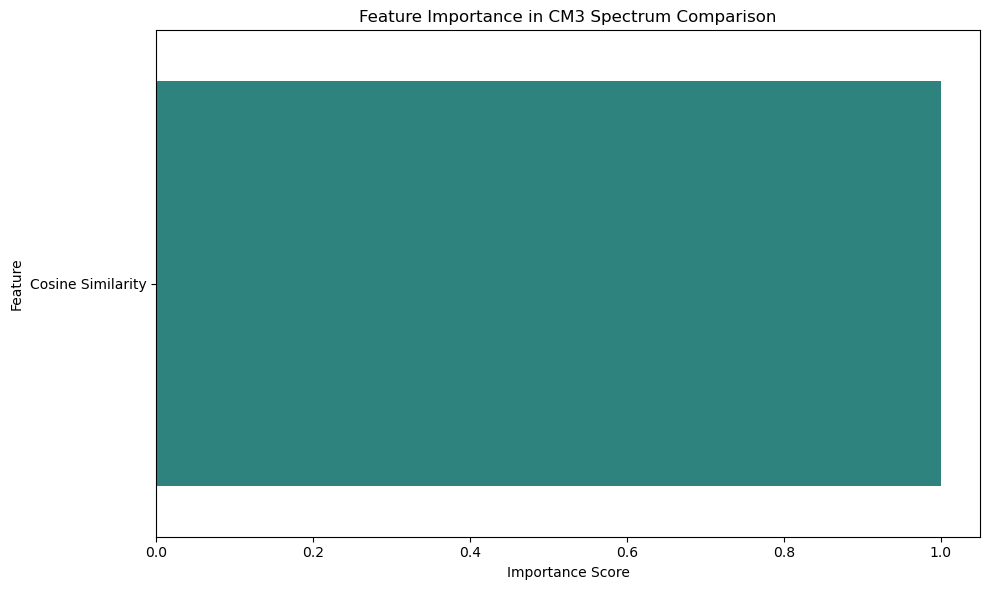


Feature Importance Rankings:
Cosine Similarity    1.0000

Simplified model and scaler saved!


In [6]:
#CM3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate similarity features between aligned spectra - using only cosine similarity"""
    try:
        # Only calculate cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def generate_balanced_comparisons(base_path, debug=False):
    """Generate balanced comparison dataset for CM3"""
    X = []  # Features
    y = []  # Labels
    comparisons = []  # File pairs
    same_count = 0    # Count of same-compound pairs
    diff_count = 0    # Count of different-compound pairs
    
    # Find all compounds
    compounds = {}
    for file in os.listdir(base_path):
        if file.endswith('.csv'):
            compound_num = int(file.split('-')[0])
            if compound_num not in compounds:
                compounds[compound_num] = []
            compounds[compound_num].append(file)
    
    if debug:
        print(f"\nFound {len(compounds)} compounds")
            
    # Generate same-compound comparisons
    for compound in compounds:
        files = compounds[compound]
        if debug:
            print(f"Processing same-compound comparisons for compound {compound}")
            
        for i, file1 in enumerate(files[:-1]):
            for file2 in files[i+1:]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((path1, path2))
                    same_count += 1
    
    # Generate different-compound comparisons
    compounds_list = list(compounds.keys())
    for i, compound1 in enumerate(compounds_list[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound1}")
            
        # Compare with next compound for balance
        compound2 = compounds_list[i+1]
        for file1 in compounds[compound1]:
            for file2 in compounds[compound2]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((path1, path2))
                    diff_count += 1
    
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

def main():
    # Set path for CM3
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM3'
    
    # Generate comparisons
    print("Generating CM3 comparisons (using only Cosine Similarity)...")
    X, y, comparisons = generate_balanced_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Create model
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        print("\nPerforming cross-validation...")
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance analysis
        feature_names = ['Cosine Similarity']
        importance = model.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in CM3 Spectrum Comparison')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Print feature importance rankings
        print("\nFeature Importance Rankings:")
        for idx, row in importance_df.iloc[::-1].iterrows():
            print(f"{row['Feature']:20} {row['Importance']:.4f}")
        
        # Save model and scaler
        model.save_model('cm3_comparison_model_simplified.json')
        import joblib
        joblib.dump(scaler, 'cm3_scaler_simplified.joblib')
        print("\nSimplified model and scaler saved!")

if __name__ == "__main__":
    main()

In [ ]:
#combined model with only cosine similarity

Generating combined comparisons using cosine similarity only...

Processing CM1...

Found 280 spectra files for CM1
Processing same-compound comparisons for CM1 compound 16
Processing same-compound comparisons for CM1 compound 18
Processing same-compound comparisons for CM1 compound 6
Processing same-compound comparisons for CM1 compound 8
Processing same-compound comparisons for CM1 compound 20
Processing same-compound comparisons for CM1 compound 4
Processing same-compound comparisons for CM1 compound 22
Processing same-compound comparisons for CM1 compound 14
Processing same-compound comparisons for CM1 compound 1
Processing same-compound comparisons for CM1 compound 25
Processing same-compound comparisons for CM1 compound 13
Processing same-compound comparisons for CM1 compound 11
Processing same-compound comparisons for CM1 compound 27
Processing same-compound comparisons for CM1 compound 3
Processing same-compound comparisons for CM1 compound 2
Processing same-compound comparison

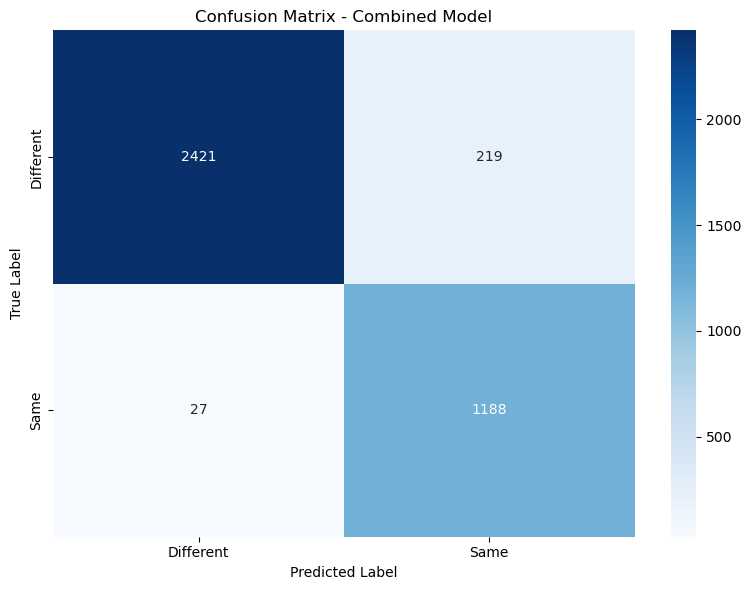

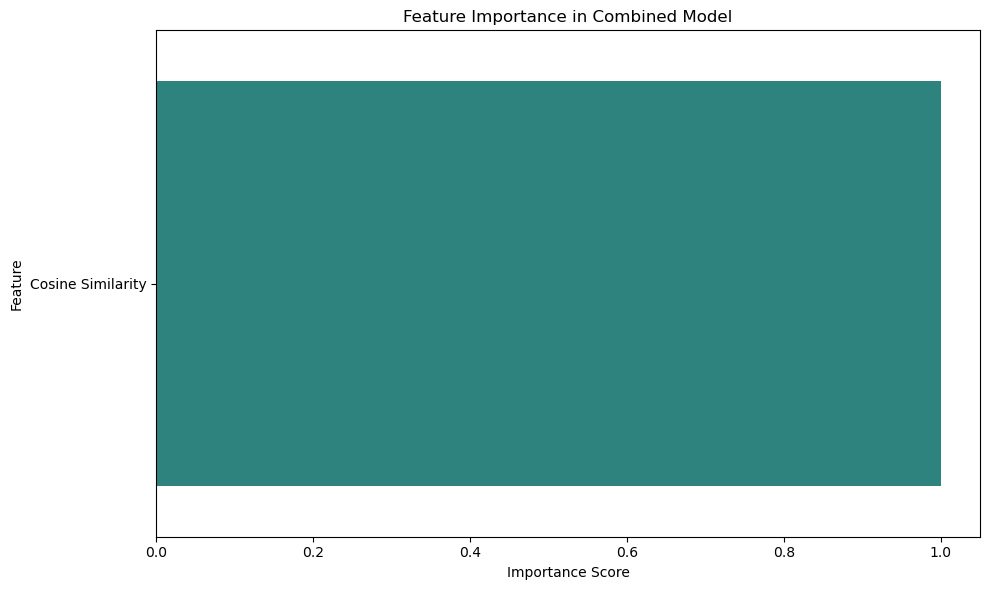


Combined model and scaler saved!


In [7]:
#Combined Model for CM1, CM2, and CM3

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate cosine similarity between aligned spectra"""
    try:
        # Calculate only cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def generate_dataset_comparisons(base_path, dataset_name, debug=False):
    """Generate comparisons for a specific dataset"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    # Find all spectra files
    spectra_files = []
    for file in os.listdir(base_path):
        if file.endswith('.csv'):
            spectra_files.append(file)
    
    if debug:
        print(f"\nFound {len(spectra_files)} spectra files for {dataset_name}")
    
    # Group files by compound
    compounds = {}
    for file in spectra_files:
        compound_num = int(file.split('-')[0])
        if compound_num not in compounds:
            compounds[compound_num] = []
        compounds[compound_num].append(file)
    
    # Generate same-compound comparisons
    for compound in compounds:
        files = compounds[compound]
        if debug:
            print(f"Processing same-compound comparisons for {dataset_name} compound {compound}")
            
        for i, file1 in enumerate(files[:-1]):
            for file2 in files[i+1:]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((dataset_name, path1, path2))
                    same_count += 1
    
    # Generate different-compound comparisons
    compounds_list = list(compounds.keys())
    for i, compound1 in enumerate(compounds_list[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for {dataset_name} compound {compound1}")
            
        # Compare with next compound for balance
        compound2 = compounds_list[i+1]
        for file1 in compounds[compound1]:
            for file2 in compounds[compound2]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((dataset_name, path1, path2))
                    diff_count += 1
    
    print(f"\n{dataset_name} Comparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    if diff_count > 0:
        print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    return np.array(X), np.array(y), comparisons

def main():
    # Base directory containing all datasets
    base_dir = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity'
    
    # Paths for each dataset
    paths = {
        'CM1': os.path.join(base_dir, 'CM1'),
        'CM2': os.path.join(base_dir, 'CM2'),
        'CM3': os.path.join(base_dir, 'CM3')
    }
    
    # Generate combined dataset
    print("Generating combined comparisons using cosine similarity only...")
    
    X_all = []
    y_all = []
    comparisons_all = []
    
    for dataset_name, path in paths.items():
        print(f"\nProcessing {dataset_name}...")
        X, y, comparisons = generate_dataset_comparisons(path, dataset_name, debug=True)
        if len(X) > 0:
            X_all.extend(X)
            y_all.extend(y)
            comparisons_all.extend(comparisons)
    
    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    print("\nTotal Dataset Statistics:")
    print(f"Total comparisons: {len(X_all)}")
    print(f"Same compound comparisons: {sum(y_all == 1)}")
    print(f"Different compound comparisons: {sum(y_all == 0)}")
    print(f"Overall class balance ratio: {sum(y_all == 1)/sum(y_all == 0):.2f}")
    
    if len(X_all) > 0:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create model
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different', 'Same'],
                    yticklabels=['Different', 'Same'])
        plt.title('Confusion Matrix - Combined Model')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': ['Cosine Similarity'],
            'Importance': model.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in Combined Model')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Save model and scaler
        model.save_model('combined_model_cosine.json')
        joblib.dump(scaler, 'combined_scaler_cosine.joblib')
        print("\nCombined model and scaler saved!")

if __name__ == "__main__":
    main()

Generating combined comparisons using cosine similarity only...

Processing CM1...

Found 280 spectra files for CM1
Processing same-compound comparisons for CM1 compound 16
Processing same-compound comparisons for CM1 compound 18
Processing same-compound comparisons for CM1 compound 6
Processing same-compound comparisons for CM1 compound 8
Processing same-compound comparisons for CM1 compound 20
Processing same-compound comparisons for CM1 compound 4
Processing same-compound comparisons for CM1 compound 22
Processing same-compound comparisons for CM1 compound 14
Processing same-compound comparisons for CM1 compound 1
Processing same-compound comparisons for CM1 compound 25
Processing same-compound comparisons for CM1 compound 13
Processing same-compound comparisons for CM1 compound 11
Processing same-compound comparisons for CM1 compound 27
Processing same-compound comparisons for CM1 compound 3
Processing same-compound comparisons for CM1 compound 2
Processing same-compound comparison

[I 2024-11-11 20:30:41,759] A new study created in memory with name: no-name-308a6c22-ca6e-4dcc-b071-6a99764e2dd1



Optimizing hyperparameters using Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-11 20:30:41,826] Trial 0 finished with value: 0.9832505611672279 and parameters: {'max_depth': 1, 'learning_rate': 0.031056974567894132, 'n_estimators': 308, 'min_child_weight': 3, 'subsample': 0.8467042933815357, 'colsample_bytree': 0.7284529516555691, 'reg_alpha': 0.00035737770571079696, 'reg_lambda': 0.09195154285967919, 'gamma': 0.010797821708158491}. Best is trial 0 with value: 0.9832505611672279.
[I 2024-11-11 20:30:41,937] Trial 1 finished with value: 0.989608897618157 and parameters: {'max_depth': 4, 'learning_rate': 0.09948550029005257, 'n_estimators': 385, 'min_child_weight': 2, 'subsample': 0.9266420211173334, 'colsample_bytree': 0.6460063858879693, 'reg_alpha': 0.031196580319588624, 'reg_lambda': 0.008548098940217417, 'gamma': 4.564400200311559e-08}. Best is trial 1 with value: 0.989608897618157.
[I 2024-11-11 20:30:42,031] Trial 2 finished with value: 0.9875035852350668 and parameters: {'max_depth': 2, 'learning_rate': 0.025416177673604434, 'n_estimators': 460, 

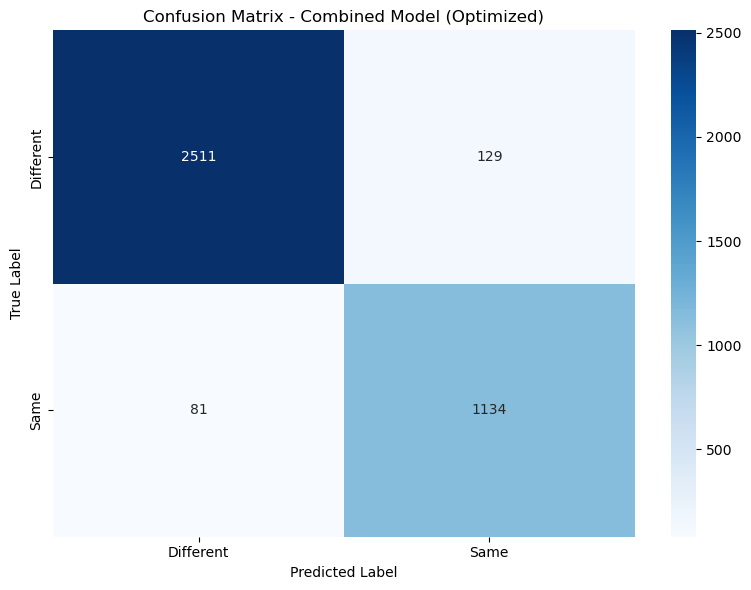

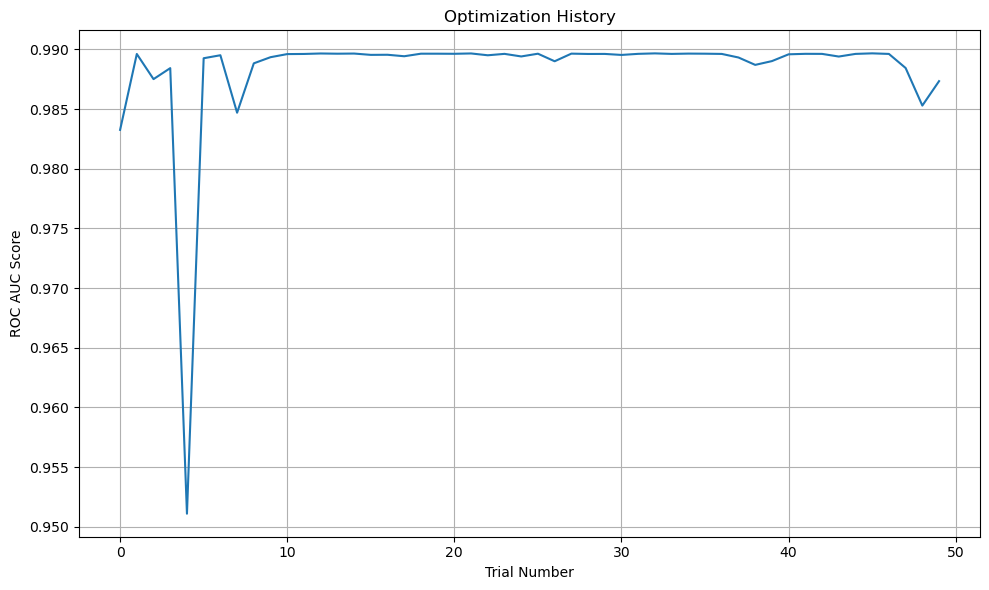

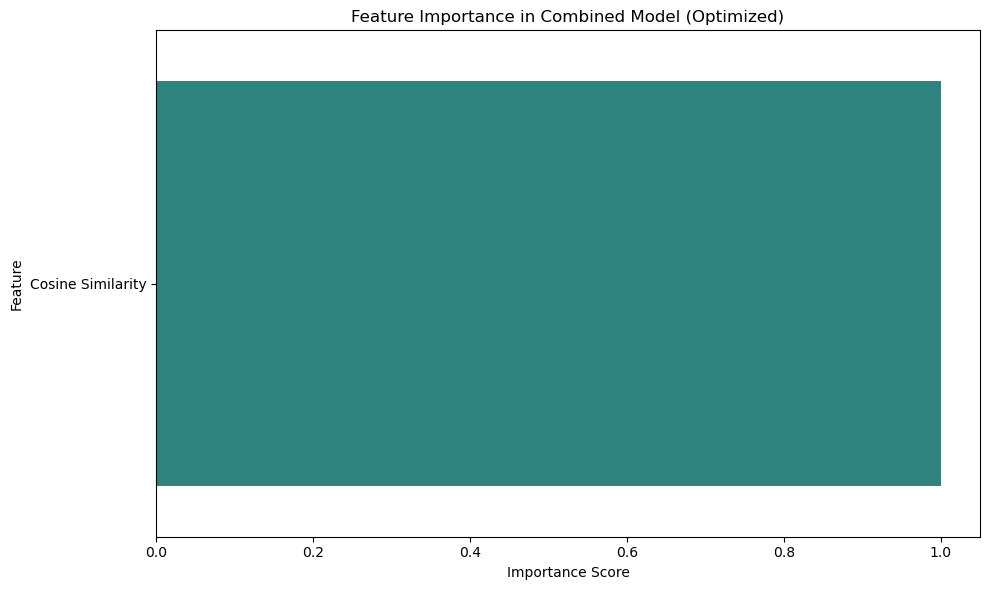


Optimized model, scaler, and optimization results saved!
Files saved with timestamp: 20241111_203057


In [9]:
# Model for CM1, CM2, and CM3 with Optuna optimization and only cosine similarity

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
import optuna
from datetime import datetime
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate cosine similarity between aligned spectra"""
    try:
        # Calculate only cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def generate_dataset_comparisons(base_path, dataset_name, debug=False):
    """Generate comparisons for a specific dataset"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    # Find all spectra files
    spectra_files = []
    for file in os.listdir(base_path):
        if file.endswith('.csv'):
            spectra_files.append(file)
    
    if debug:
        print(f"\nFound {len(spectra_files)} spectra files for {dataset_name}")
    
    # Group files by compound
    compounds = {}
    for file in spectra_files:
        compound_num = int(file.split('-')[0])
        if compound_num not in compounds:
            compounds[compound_num] = []
        compounds[compound_num].append(file)
    
    # Generate same-compound comparisons
    for compound in compounds:
        files = compounds[compound]
        if debug:
            print(f"Processing same-compound comparisons for {dataset_name} compound {compound}")
            
        for i, file1 in enumerate(files[:-1]):
            for file2 in files[i+1:]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((dataset_name, path1, path2))
                    same_count += 1
    
    # Generate different-compound comparisons
    compounds_list = list(compounds.keys())
    for i, compound1 in enumerate(compounds_list[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for {dataset_name} compound {compound1}")
            
        # Compare with next compound for balance
        compound2 = compounds_list[i+1]
        for file1 in compounds[compound1]:
            for file2 in compounds[compound2]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((dataset_name, path1, path2))
                    diff_count += 1
    
    print(f"\n{dataset_name} Comparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    if diff_count > 0:
        print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    return np.array(X), np.array(y), comparisons

def objective(trial, X_train, X_test, y_train, y_test):
    """Objective function for Optuna optimization"""
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'objective': 'binary:logistic',
        'random_state': 42,
        'use_label_encoder': False
    }
    
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # Use ROC-AUC as optimization metric
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    
    return score

def main():
    # Base directory containing all datasets
    base_dir = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity'
    
    # Paths for each dataset
    paths = {
        'CM1': os.path.join(base_dir, 'CM1'),
        'CM2': os.path.join(base_dir, 'CM2'),
        'CM3': os.path.join(base_dir, 'CM3')
    }
    
    # Generate combined dataset
    print("Generating combined comparisons using cosine similarity only...")
    
    X_all = []
    y_all = []
    comparisons_all = []
    
    for dataset_name, path in paths.items():
        print(f"\nProcessing {dataset_name}...")
        X, y, comparisons = generate_dataset_comparisons(path, dataset_name, debug=True)
        if len(X) > 0:
            X_all.extend(X)
            y_all.extend(y)
            comparisons_all.extend(comparisons)
    
    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    print("\nTotal Dataset Statistics:")
    print(f"Total comparisons: {len(X_all)}")
    print(f"Same compound comparisons: {sum(y_all == 1)}")
    print(f"Different compound comparisons: {sum(y_all == 0)}")
    print(f"Overall class balance ratio: {sum(y_all == 1)/sum(y_all == 0):.2f}")
    
    if len(X_all) > 0:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Optimize hyperparameters using Optuna
        print("\nOptimizing hyperparameters using Optuna...")
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, X_train_scaled, X_test_scaled, y_train, y_test),
                      n_trials=50, show_progress_bar=True)
        
        best_params = study.best_params
        print("\nBest hyperparameters:", best_params)
        
        # Create model with optimized parameters
        model = xgb.XGBClassifier(
            **best_params,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False
        )
        
        # Perform cross-validation with optimized model
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different', 'Same'],
                    yticklabels=['Different', 'Same'])
        plt.title('Confusion Matrix - Combined Model (Optimized)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Plot optimization history
        plt.figure(figsize=(10, 6))
        trial_numbers = [t.number for t in study.trials]
        trial_values = [t.value for t in study.trials]
        plt.plot(trial_numbers, trial_values)
        plt.title('Optimization History')
        plt.xlabel('Trial Number')
        plt.ylabel('ROC AUC Score')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': ['Cosine Similarity'],
            'Importance': model.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in Combined Model (Optimized)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Save optimized model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model.save_model(f'combined_model_cosine_optimized_{timestamp}.json')
        joblib.dump(scaler, f'combined_scaler_cosine_optimized_{timestamp}.joblib')
        
        # Save optimization results
        optimization_results = {
            'best_params': best_params,
            'best_score': study.best_value,
            'optimization_history': {
                'trial_numbers': trial_numbers,
                'trial_values': trial_values
            },
            'cv_scores': cv_scores.tolist(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_roc_auc': roc_auc_score(y_test, y_prob)
        }
        joblib.dump(optimization_results, f'optimization_results_{timestamp}.joblib')
        
        print("\nOptimized model, scaler, and optimization results saved!")
        print(f"Files saved with timestamp: {timestamp}")

if __name__ == "__main__":
    main()